In [3]:
pip install xgboost pandas scikit-learn matplotlib
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

Fighter Stats Columns: ['name', 'wins', 'losses', 'height', 'weight', 'reach', 'stance', 'age', 'SLpM', 'sig_str_acc', 'SApM', 'str_def', 'td_avg', 'td_acc', 'td_def', 'sub_avg']
Large Dataset Columns: ['event_name', 'r_fighter', 'b_fighter', 'winner', 'weight_class', 'is_title_bout', 'gender', 'method', 'finish_round', 'total_rounds', 'time_sec', 'referee', 'r_kd', 'r_sig_str', 'r_sig_str_att', 'r_sig_str_acc', 'r_str', 'r_str_att', 'r_str_acc', 'r_td', 'r_td_att', 'r_td_acc', 'r_sub_att', 'r_rev', 'r_ctrl_sec', 'r_wins_total', 'r_losses_total', 'r_age', 'r_height', 'r_weight', 'r_reach', 'r_stance', 'r_SLpM_total', 'r_SApM_total', 'r_sig_str_acc_total', 'r_td_acc_total', 'r_str_def_total', 'r_td_def_total', 'r_sub_avg', 'r_td_avg', 'b_kd', 'b_sig_str', 'b_sig_str_att', 'b_sig_str_acc', 'b_str', 'b_str_att', 'b_str_acc', 'b_td', 'b_td_att', 'b_td_acc', 'b_sub_att', 'b_rev', 'b_ctrl_sec', 'b_wins_total', 'b_losses_total', 'b_age', 'b_height', 'b_weight', 'b_reach', 'b_stance', 'b_SLpM_

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.72
              precision    recall  f1-score   support

           0       0.69      0.52      0.59       506
           1       0.73      0.85      0.78       770

    accuracy                           0.72      1276
   macro avg       0.71      0.68      0.69      1276
weighted avg       0.71      0.72      0.71      1276



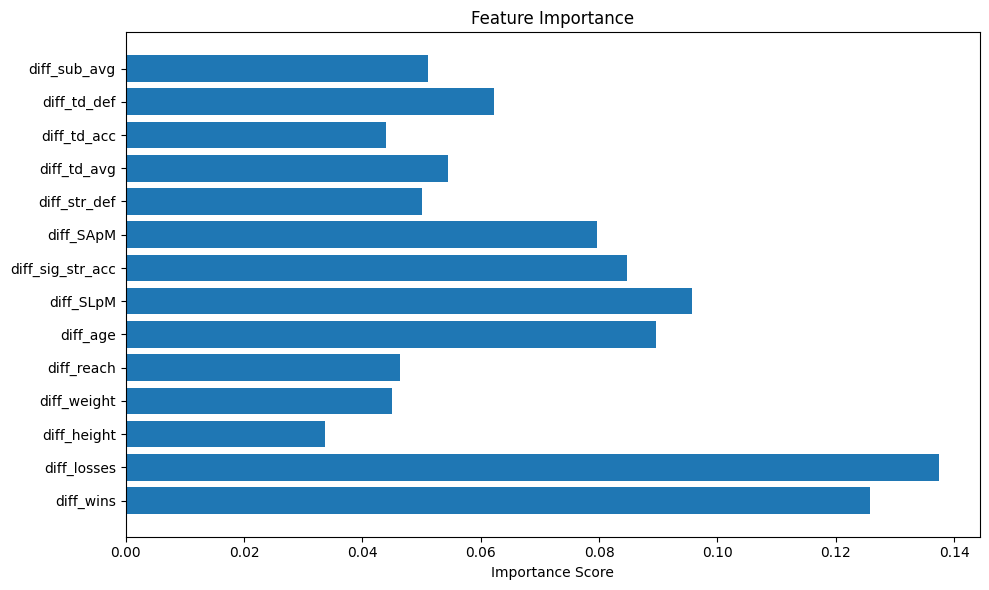

In [4]:
fighter_df = pd.read_csv("fighter_stats.csv")
print("Fighter Stats Columns:", fighter_df.columns.tolist())
fight_df = pd.read_csv("large_dataset.csv")
print("Large Dataset Columns:", fight_df.columns.tolist())

# Step 2: Merge red corner stats
fight_df = fight_df.merge(
    fighter_df,
    how='left',
    left_on='r_fighter',
    right_on='name',
    suffixes=('', '_r')
)

# Step 3: Merge blue corner stats
fight_df = fight_df.merge(
    fighter_df,
    how='left',
    left_on='b_fighter',
    right_on='name',
    suffixes=('', '_b')
)

# Step 4: Drop duplicate name columns
fight_df = fight_df.drop(columns=['name', 'name_b'])

# Step 5: Create difference features
numeric_stats = ['wins', 'losses', 'height', 'weight', 'reach', 'age', 'SLpM', 'sig_str_acc', 'SApM',
                 'str_def', 'td_avg', 'td_acc', 'td_def', 'sub_avg']

for col in numeric_stats:
    try:
        fight_df[f'diff_{col}'] = fight_df[f'{col}'] - fight_df[f'{col}_b']  # red - blue
    except KeyError:
        print(f"Missing: {col}, skipping")

# Step 6: Clean data
# Drop rows with missing values (simple strategy for now)
fight_df = fight_df.dropna()

# Step 7: Set up features and target
feature_cols = [col for col in fight_df.columns if col.startswith("diff_")]
X = fight_df[feature_cols]
y = (fight_df['winner'] == 'Red').astype(int)  # 1 if Red won, 0 if Blue won

# Step 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Train XGBoost model
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.08,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# Step 10: Evaluate
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# Step 11: Feature importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns, model.feature_importances_)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


🔍 Columns in dataset: ['RedFighter', 'BlueFighter', 'RedOdds', 'BlueOdds', 'RedExpectedValue', 'BlueExpectedValue', 'Date', 'Location', 'Country', 'Winner', 'TitleBout', 'WeightClass', 'Gender', 'NumberOfRounds', 'BlueCurrentLoseStreak', 'BlueCurrentWinStreak', 'BlueDraws', 'BlueAvgSigStrLanded', 'BlueAvgSigStrPct', 'BlueAvgSubAtt', 'BlueAvgTDLanded', 'BlueAvgTDPct', 'BlueLongestWinStreak', 'BlueLosses', 'BlueTotalRoundsFought', 'BlueTotalTitleBouts', 'BlueWinsByDecisionMajority', 'BlueWinsByDecisionSplit', 'BlueWinsByDecisionUnanimous', 'BlueWinsByKO', 'BlueWinsBySubmission', 'BlueWinsByTKODoctorStoppage', 'BlueWins', 'BlueStance', 'BlueHeightCms', 'BlueReachCms', 'BlueWeightLbs', 'RedCurrentLoseStreak', 'RedCurrentWinStreak', 'RedDraws', 'RedAvgSigStrLanded', 'RedAvgSigStrPct', 'RedAvgSubAtt', 'RedAvgTDLanded', 'RedAvgTDPct', 'RedLongestWinStreak', 'RedLosses', 'RedTotalRoundsFought', 'RedTotalTitleBouts', 'RedWinsByDecisionMajority', 'RedWinsByDecisionSplit', 'RedWinsByDecisionUnani

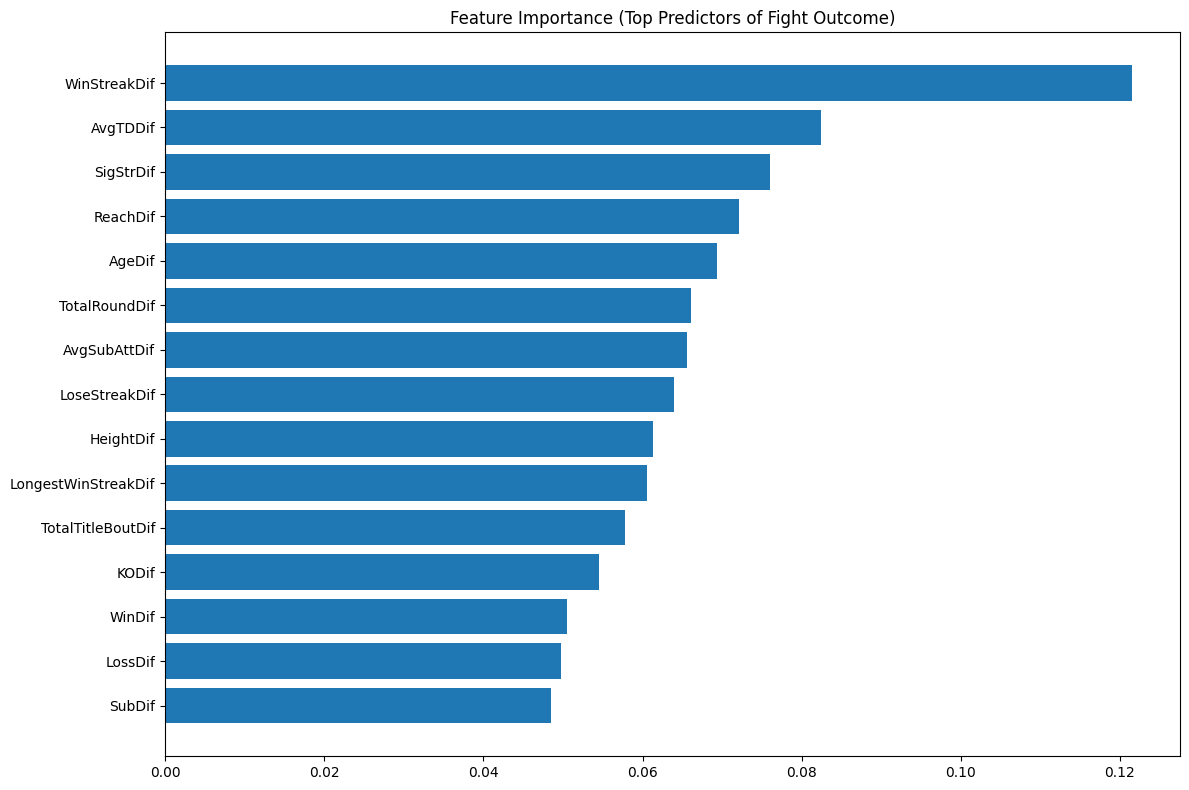

In [5]:
# Step 1: Load UFC Master dataset
df = pd.read_csv("ufc-master.csv")
print("🔍 Columns in dataset:", df.columns.tolist())

# Step 2: Select only relevant numeric 'Dif' features
feature_cols = [col for col in df.columns if "Dif" in col and df[col].dtype in [np.float64, np.int64]]
required_cols = feature_cols + ["Winner"]

# Step 3: Drop rows that have missing values only in the relevant columns
df_filtered = df[required_cols].dropna()

# Step 4: Prepare features and labels
X = df_filtered[feature_cols]
y = (df_filtered["Winner"] == "Red").astype(int)  # 1 if Red wins, else 0

print(f"✅ Dataset size: {len(X)} rows, {len(feature_cols)} features.")

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train XGBoost model
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# Step 7: Make predictions
y_pred = model.predict(X_test)

# Step 8: Evaluation
print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Step 9: Feature importance visualization
importances = model.feature_importances_
sorted_idx = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.barh(np.array(feature_cols)[sorted_idx], importances[sorted_idx])
plt.title("Feature Importance (Top Predictors of Fight Outcome)")
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Accuracy: 0.72
              precision    recall  f1-score   support

           0       0.61      0.54      0.57       514
           1       0.77      0.82      0.79       979

    accuracy                           0.72      1493
   macro avg       0.69      0.68      0.68      1493
weighted avg       0.71      0.72      0.72      1493



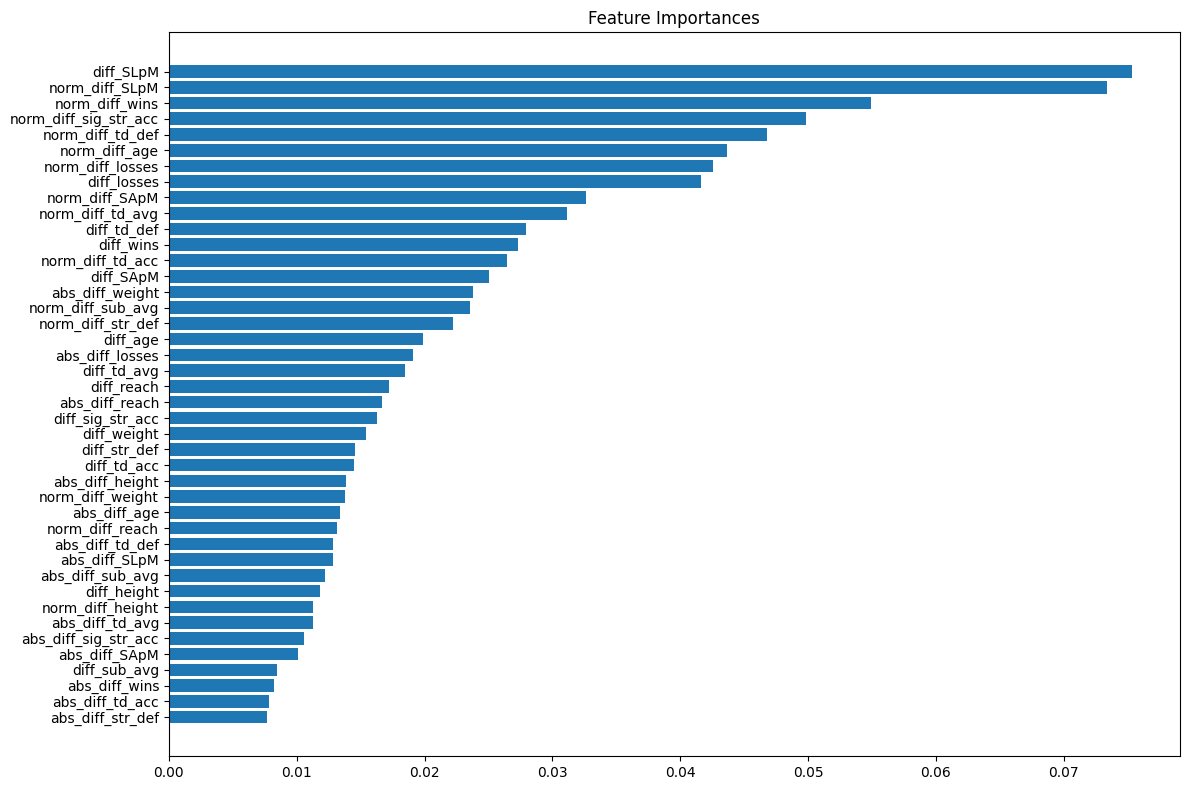

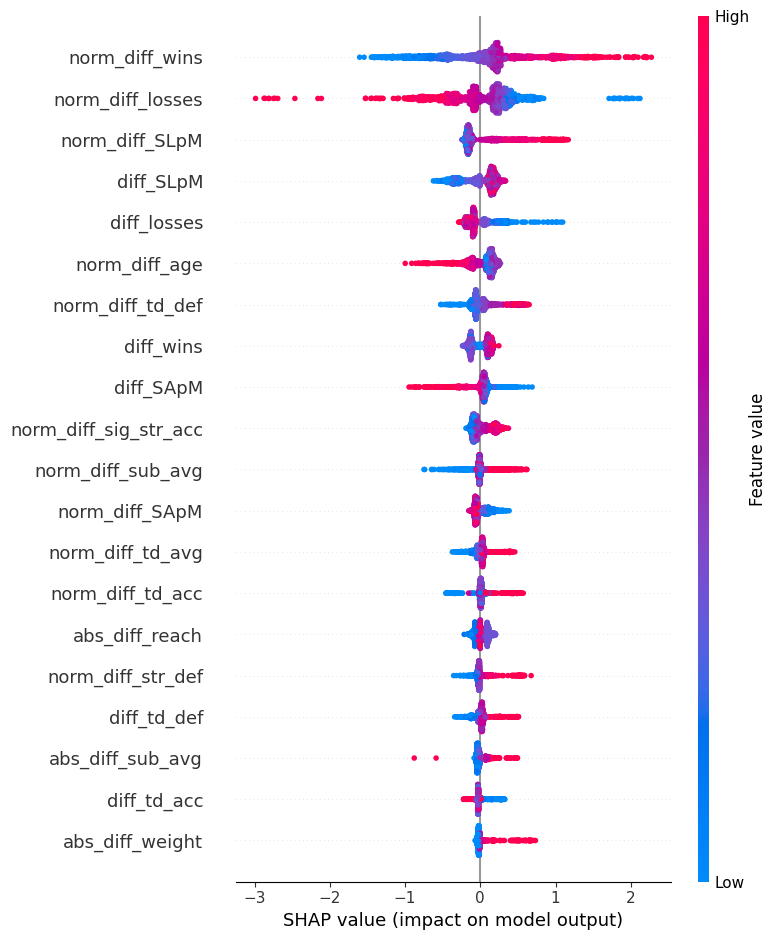

In [6]:
# Load datasets
fighter_df = pd.read_csv("fighter_stats.csv")
fight_df = pd.read_csv("large_dataset.csv")

# Merge red corner stats
fight_df = fight_df.merge(fighter_df, how='left', left_on='r_fighter', right_on='name', suffixes=('', '_r'))

# Merge blue corner stats
fight_df = fight_df.merge(fighter_df, how='left', left_on='b_fighter', right_on='name', suffixes=('', '_b'))

# Drop duplicate fighter names
fight_df = fight_df.drop(columns=['name', 'name_b'])

# Define relevant stats
numeric_stats = ['wins', 'losses', 'height', 'weight', 'reach', 'age', 'SLpM', 'sig_str_acc',
                 'SApM', 'str_def', 'td_avg', 'td_acc', 'td_def', 'sub_avg']

# Feature engineering: diff, abs_diff, and norm_diff
for col in numeric_stats:
    try:
        red = fight_df[col]
        blue = fight_df[f"{col}_b"]
        fight_df[f'diff_{col}'] = red - blue
        fight_df[f'abs_diff_{col}'] = np.abs(red - blue)
        fight_df[f'norm_diff_{col}'] = (red - blue) / (red + blue + 1e-5)
    except KeyError:
        print(f"Missing {col}, skipping")

# Drop rows with missing target
fight_df = fight_df[fight_df['winner'].notna()]

# Impute remaining missing values
imputer = SimpleImputer(strategy='median')
features = [col for col in fight_df.columns if col.startswith(('diff_', 'abs_diff_', 'norm_diff_'))]
X = pd.DataFrame(imputer.fit_transform(fight_df[features]), columns=features)

# Encode target
y = (fight_df['winner'] == 'Red').astype(int)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}
xgb_model = XGBClassifier(eval_metric='logloss')

search = RandomizedSearchCV(xgb_model, param_distributions=param_grid,
                            n_iter=20, cv=5, scoring='accuracy', verbose=1, random_state=42)
search.fit(X_train, y_train)
best_model = search.best_estimator_

# Predict probabilities and apply thresholding
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.55).astype(int)

# Evaluation
print("Best Parameters:", search.best_params_)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# Plot feature importance
plt.figure(figsize=(12, 8))
sorted_idx = np.argsort(best_model.feature_importances_)
plt.barh(np.array(features)[sorted_idx], best_model.feature_importances_[sorted_idx])
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# SHAP Explainability
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)
